## Lab 4

In this lab, we will get practice with Spark. We will focus on Spark SQL which allows us to store data in Spark DataFrames. We will learn that the operations on tables in Spark resemble the operations on table in Python and SQL.  

In [2]:
# import some packages 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# change some settings

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 8)
plt.rcParams['figure.figsize'] = (15,7)

#### Connect to Spark

Remember that Spark has support for multiple programming languages. Here we will connect to Spark through Python with the `pyspark` package. 

In [3]:
# import packages for Spark

import pyspark
from pyspark.sql import functions as F

While Spark has several components, we will be working with Spark SQL. We access Spark SQL through Python with the module `pyspark.sql`.

In [4]:
spark = pyspark.sql.SparkSession.builder.master("local").getOrCreate()

We need to start a Spark session. Here we can configure the scheduler node and worker nodes. Since we will not work on a cluster like NYU Dumbo cluster, we can specify `local` to indicate our local computers.

#### Load Data

We will be working with data about the Vietnam War. The Vietnam War was a conflict in Vietnam, Laos, and Cambodia fought between North Vietnam and South Vietnam from November 1, 1955 to April 30, 1975. Following the war, governmental and non-govermental organizations have worked to provide [relief to war-torn areas](https://www.reuters.com/article/us-laos-obama-uxo/u-s-gives-laos-extra-90-million-to-help-clear-unexploded-ordnance-idUSKCN11C0GV).

The datasets come from a database about the [United States Air Force](https://www.kaggle.com/usaf/vietnam-war-bombing-operations). Records of combat missions in the database have allowed researchers to locate unexploded bombs throughout Southeast Asia. Organizations have defused unexploded bombs in their relief efforts. 

Determing the location of unexploded bombs involves mining the data for information

- Which combat missions involved bombings?
- Which months had many combat missions?
- What aircrafts participated in the combat missions?

We will work with two datasets.

In [5]:
home = os.environ["HOME"]
path_folder = f"{home}/shared/lab-4/" 

path_Bombing_Operations = path_folder + "Bombing_Operations.json.gz"
path_Aircraft_Glossary = path_folder + "Aircraft_Glossary.json.gz"

The dataset `Bombing_Operations` has 4400775 rows and 9 columns

- AirCraft: _Aircraft model_
- ContryFlyingMission: _Country_
- MissionDate: _Date of the mission_
- OperationSupported: _Supported War operation_ 
- PeriodOfDay: _Day or night_
- TakeoffLocation: _Take off airport_
- TimeOnTarget: _Time of bombing_
- WeaponType: _Type of weapon_
- WeaponsLoadedWeight: _Weight of weapon_

The dataset `Aircraft_Glossary` has 104 rows and 3 columns

- AirCraft: _Aircraft model_
- AirCraftName: _Name of Aircraft_
- AirCraftType: _Type of Aircraft_

In [6]:
Bombing_Operations = spark.read.json(path_Bombing_Operations)
Aircraft_Glossary = spark.read.json(path_Aircraft_Glossary)

We have stored the datasets as files in the `shared/` folder

- The file extension `gz` means that the files are compressed. Here `gz` stands for the gunzip compression format
- The file extension `json` means the files have a semi-structured format. Remember that `json` stands for Javascript Object Notation. The format consists of key-value pairs that resemble dictionaries in Python.

We can check the schema with the function `printSchema`.

In [7]:
Bombing_Operations.printSchema()

root
 |-- AirCraft: string (nullable = true)
 |-- ContryFlyingMission: string (nullable = true)
 |-- MissionDate: string (nullable = true)
 |-- OperationSupported: string (nullable = true)
 |-- PeriodOfDay: string (nullable = true)
 |-- TakeoffLocation: string (nullable = true)
 |-- TargetCountry: string (nullable = true)
 |-- TimeOnTarget: double (nullable = true)
 |-- WeaponType: string (nullable = true)
 |-- WeaponsLoadedWeight: long (nullable = true)



In [8]:
Aircraft_Glossary.printSchema()

root
 |-- AirCraft: string (nullable = true)
 |-- AirCraftName: string (nullable = true)
 |-- AirCraftType: string (nullable = true)



The schema indicate 
- name 
- data type 
- constraint about missing values

for each column. We can access records with `take`.

In [12]:
Bombing_Operations.take(3)

[Row(AirCraft='EC-47', ContryFlyingMission='UNITED STATES OF AMERICA', MissionDate='1971-06-05', OperationSupported=None, PeriodOfDay='D', TakeoffLocation='TAN SON NHUT', TargetCountry='CAMBODIA', TimeOnTarget=1005.0, WeaponType=None, WeaponsLoadedWeight=0),
 Row(AirCraft='EC-47', ContryFlyingMission='UNITED STATES OF AMERICA', MissionDate='1972-12-26', OperationSupported=None, PeriodOfDay='D', TakeoffLocation='NAKHON PHANOM', TargetCountry='SOUTH VIETNAM', TimeOnTarget=530.0, WeaponType=None, WeaponsLoadedWeight=0),
 Row(AirCraft='RF-4', ContryFlyingMission='UNITED STATES OF AMERICA', MissionDate='1973-07-28', OperationSupported=None, PeriodOfDay='D', TakeoffLocation='UDORN AB', TargetCountry='LAOS', TimeOnTarget=730.0, WeaponType=None, WeaponsLoadedWeight=0)]

Note that we have a Spark DataFrame not a Spark RDD. The data appears in rows and columns. If we use the function `show` then we can view records in a tabular format.

In [10]:
Aircraft_Glossary.show(5)

+--------+--------------------+--------------------+
|AirCraft|        AirCraftName|        AirCraftType|
+--------+--------------------+--------------------+
|     A-1|Douglas A-1 Skyra...|         Fighter Jet|
|    A-26|Douglas A-26 Invader|        Light Bomber|
|    A-37|Cessna A-37 Drago...|Light ground-atta...|
|     A-4|McDonnell Douglas...|         Fighter Jet|
|     A-5|North American A-...|          Bomber Jet|
+--------+--------------------+--------------------+
only showing top 5 rows



#### Countries in Conflict

While North Vietnam and South Vietnam fought in the Vietnam War, many countries including the United States participated in the conflict. We can determine the different countries.

We can group the missions by `ContryFlyingMission` to count the number of records.

In [11]:
missions_counts = Bombing_Operations.groupBy("ContryFlyingMission").agg({"MissionDate" : "count"})

missions_counts.show()

+--------------------+------------------+
| ContryFlyingMission|count(MissionDate)|
+--------------------+------------------+
|     VIETNAM (SOUTH)|            622013|
|       KOREA (SOUTH)|             24469|
|UNITED STATES OF ...|           3708997|
|           AUSTRALIA|             12519|
|                LAOS|             32777|
+--------------------+------------------+



Here we use the `agg` function to aggregate entries in the `MissionDate` column. 

We can rename columns using `withColumnRenamed`. We can sort the entries in columns with `orderBy`.


In [15]:
missions_counts = ( Bombing_Operations.groupBy("ContryFlyingMission")
                                    .agg({"MissionDate" : "count"})
                                    .withColumnRenamed("count(MissionDate)", "MissionCount")
                                    .orderBy("MissionCount", ascending = False)  )
missions_counts.show()

+--------------------+------------+
| ContryFlyingMission|MissionCount|
+--------------------+------------+
|UNITED STATES OF ...|     3708997|
|     VIETNAM (SOUTH)|      622013|
|                LAOS|       32777|
|       KOREA (SOUTH)|       24469|
|           AUSTRALIA|       12519|
+--------------------+------------+



Note that parentheses allow us to spread the commands across several lines.


The `agg` function is versatile. We can use different functions in `pyspark.sql.functions` to aggregate the data.

In [16]:
missions_counts = ( Bombing_Operations.groupBy("ContryFlyingMission")
                                    .agg(F.count("*").alias("MissionCount"))
                                    .orderBy("MissionCount", ascending = False)  )
missions_counts.show()

+--------------------+------------+
| ContryFlyingMission|MissionCount|
+--------------------+------------+
|UNITED STATES OF ...|     3708997|
|     VIETNAM (SOUTH)|      622013|
|                LAOS|       32777|
|       KOREA (SOUTH)|       24469|
|           AUSTRALIA|       12519|
+--------------------+------------+



If we want to use operations like SQL, then we need to register a table in the Spark session.

In [12]:
Bombing_Operations.createOrReplaceTempView("Bombing_Operations")

Here we have added `Bombing_Operations` to the Spark session. Now we can execute a query indicating `Bombing_Operations`.

In [13]:
query = """
SELECT ContryFlyingMission, COUNT(*) as MissionsCount
FROM Bombing_Operations
GROUP BY ContryFlyingMission
ORDER BY MissionsCount DESC
"""

missions_counts = spark.sql(query)
missions_counts.show()

+--------------------+-------------+
| ContryFlyingMission|MissionsCount|
+--------------------+-------------+
|UNITED STATES OF ...|      3708997|
|     VIETNAM (SOUTH)|       622013|
|                LAOS|        32777|
|       KOREA (SOUTH)|        24469|
|           AUSTRALIA|        12519|
+--------------------+-------------+



Since the Spark Dataframe is small, we can generate a pandas DataFrame.

In [14]:
missions_count_pandas = missions_counts.toPandas()

missions_count_pandas.head()

,ContryFlyingMission,MissionsCount
0,UNITED STATES OF AMERICA,3708997
1,VIETNAM (SOUTH),622013
2,LAOS,32777
3,KOREA (SOUTH),24469
4,AUSTRALIA,12519


Now that we have a pandas DataFrame, we can generate a barchart with the number of missions by country.

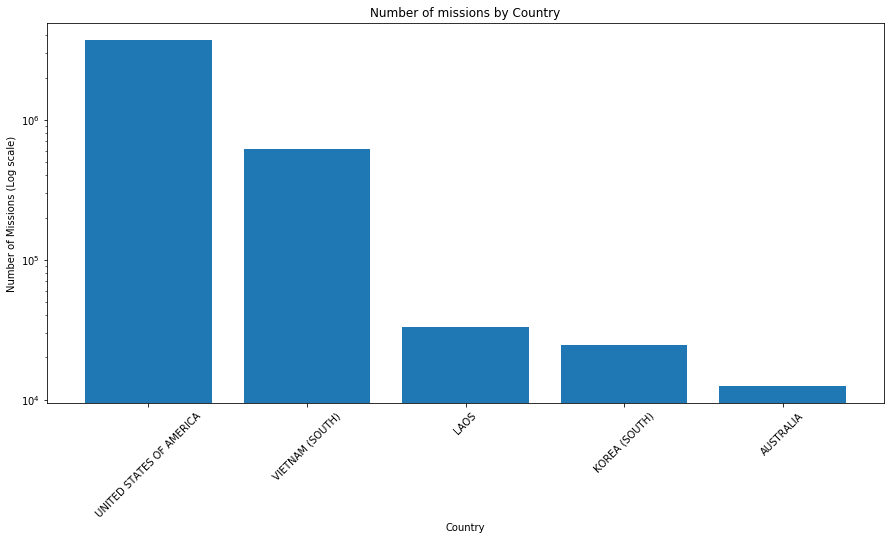

In [22]:
plt.bar(missions_count_pandas["ContryFlyingMission"], missions_count_pandas["MissionsCount"], log = True)

plt.xticks(rotation = 45)
plt.xlabel("Country")
plt.ylabel("Number of Missions (Log scale)")

plt.title("Number of missions by Country");

Note that we use a logarithmic scale where the intervals differ by factors of 10.

#### Number of Combat Missions

Throughout the engagement, the US, Vietnam, Laos, Korea and Australia participated in many combat missions. We can count the number of combat missions over time by accessing `ContryFlyingMission` and `MissionDate` columns of the Spark DataFrame. 

In [15]:
mission_countries = Bombing_Operations.select(["MissionDate", "ContryFlyingMission"])

We learn from the schema that the entries in the `MissionDate` column are strings.

In [25]:
mission_countries.printSchema()

root
 |-- MissionDate: date (nullable = true)
 |-- ContryFlyingMission: string (nullable = true)



We can convert to a date data type with the function `to_date`.

In [16]:
mission_countries = Bombing_Operations.select(F.to_date(Bombing_Operations.MissionDate).alias("MissionDate"), Bombing_Operations.ContryFlyingMission)

Now we find that the column has the appropriate data type.

In [17]:
mission_countries.printSchema()

root
 |-- MissionDate: date (nullable = true)
 |-- ContryFlyingMission: string (nullable = true)



We can group by `MissionDate` and `ContryFlyingMission` to get the count over time.

In [18]:
missions_by_date = ( mission_countries
                    .groupBy(["MissionDate", "ContryFlyingMission"])
                    .agg(F.count("*").alias("MissionsCount"))
                    .orderBy("MissionDate", ascending = False)
                    .toPandas() )

missions_by_date

,MissionDate,ContryFlyingMission,MissionsCount
0,1975-06-30,UNITED STATES OF AMERICA,17
1,1975-06-29,UNITED STATES OF AMERICA,15
2,1975-06-28,UNITED STATES OF AMERICA,22
3,1975-06-27,UNITED STATES OF AMERICA,30
4,1975-06-26,UNITED STATES OF AMERICA,25
...,...,...,...
9698,1965-10-05,VIETNAM (SOUTH),72
9699,1965-10-04,UNITED STATES OF AMERICA,532
9700,1965-10-03,UNITED STATES OF AMERICA,608
9701,1965-10-02,UNITED STATES OF AMERICA,652


Plotting the number of combat missions, we find differences between the five countries.

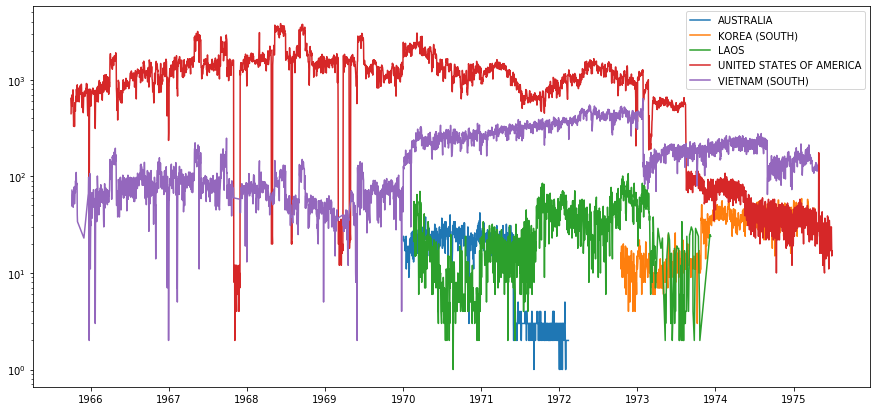

In [19]:
for country, missions in missions_by_date.groupby("ContryFlyingMission"): 
    plt.plot(missions["MissionDate"], missions["MissionsCount"], label=country)

plt.yscale("log")    
plt.legend();

We can observe how South Vietnam increased its missions starting from 1970. The drop in 1973 is motivated by the [Paris Peace Accords](https://en.wikipedia.org/wiki/Paris_Peace_Accords) that took place on January 27th, 1973.

#### Location of Conflict

The United States Air Force attacked the Hanoi POL facility in North Vietnam on June 29, 1966. We can check the various departure of the aircraft on June 29, 1966.

In [20]:
jun_29_operations = Bombing_Operations.where("MissionDate = '1966-06-29' AND TargetCountry='NORTH VIETNAM'")

Note that the function `where` allows us to filter the entries of a Spark DataFrame.

In [22]:
takeoff_mission_counts = (jun_29_operations.groupBy("ContryFlyingMission")
                                           .agg(F.count("*").alias("MissionsCount"))
                                           .toPandas())

takeoff_mission_counts

,ContryFlyingMission,MissionsCount
0,VIETNAM (SOUTH),6
1,UNITED STATES OF AMERICA,389


Now that we have the relevant records, we can count the number of departures. Most of the operation that day were performed by US aircrafts.

Before we calculate the locations of departure, we can cache the `jun_29_operations` Spark DataFrame in memory.

In [23]:
jun_29_operations.cache()

DataFrame[AirCraft: string, ContryFlyingMission: string, MissionDate: string, OperationSupported: string, PeriodOfDay: string, TakeoffLocation: string, TargetCountry: string, TimeOnTarget: double, WeaponType: string, WeaponsLoadedWeight: bigint]

By caching the content in memory, we can quickly retrieve it for operations.

In [24]:
%%timeit -n 1 -r 1 

jun_29_operations.count()

19.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Remember that Spark employs lazy evaluation. So Spark does not add `jun_29_operations` to the cache until we apply use an action. 

In [25]:
%%timeit -n 1 -r 1 
 
jun_29_operations.count()

87.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


After the content resides in memory, we find an improvement in performance. 

If we want to store the data on disk instead of memory, then we can save it to a file.

In [26]:
jun_29_operations.write.mode('overwrite').json("jun_29_operations.json")

Since we stored the data in the json format, we need to load it with `spark.read.json`.

In [27]:
jun_29_operations = spark.read.json("jun_29_operations.json")

Now we can determine the various departure locations of the aircrafts.

In [28]:
takeoff_location_counts = ( jun_29_operations
                            .groupBy("TakeoffLocation")
                            .agg(F.count("*").alias("MissionsCount"))
                            .orderBy("MissionsCount", ascending = False) )

takeoff_location_counts.show()

+----------------+-------------+
| TakeoffLocation|MissionsCount|
+----------------+-------------+
|   CONSTELLATION|           87|
|          TAKHLI|           56|
|           KORAT|           55|
|        UDORN AB|           44|
|         UBON AB|           44|
|          DANANG|           35|
|          RANGER|           35|
|    TAN SON NHUT|           26|
|HANCOCK (CVA-19)|           10|
|    CAM RANH BAY|            2|
|         CUBI PT|            1|
+----------------+-------------+



#### Spark Core

Just like a pandas DataFrame has an underlying numpy array, a Spark DataFrame has an underlying Spark RDD. 

In [29]:
jun_29_operations_rdd = jun_29_operations.rdd

Now we can perform the calculation with map-reduce on the Spark RDD.

In [30]:
jun_29_operations_rdd_mapped = jun_29_operations_rdd.map(lambda row : (row.TakeoffLocation, 1))

jun_29_operations_rdd_mapped.take(3)

[('TAKHLI', 1), ('DANANG', 1), ('CONSTELLATION', 1)]

Having performed the map step, we can sum the values in the reduce step. Note that Spark will perform the shuffling for us.

In [32]:
jun_29_operations_rdd_reduced = jun_29_operations_rdd_mapped.reduceByKey(lambda a, b: a+b)

jun_29_operations_rdd_reduced.collect()

[('TAKHLI', 56),
 ('DANANG', 35),
 ('CONSTELLATION', 87),
 ('UBON AB', 44),
 ('UDORN AB', 44),
 ('KORAT', 55),
 ('RANGER', 35),
 ('HANCOCK (CVA-19)', 10),
 ('TAN SON NHUT', 26),
 ('CUBI PT', 1),
 ('CAM RANH BAY', 2)]

We can sort by the values. By default, sorting is ascending order.

In [33]:
jun_29_operations_rdd_reduced = (jun_29_operations_rdd_mapped.reduceByKey(lambda a, b: a+b)
                                                             .sortBy(lambda entry: -entry[1]))

jun_29_operations_rdd_reduced.collect()

[('CONSTELLATION', 87),
 ('TAKHLI', 56),
 ('KORAT', 55),
 ('UBON AB', 44),
 ('UDORN AB', 44),
 ('DANANG', 35),
 ('RANGER', 35),
 ('TAN SON NHUT', 26),
 ('HANCOCK (CVA-19)', 10),
 ('CAM RANH BAY', 2),
 ('CUBI PT', 1)]

Just like we can convert a Spark DataFrame to a Spark RDD, we can convert a Spark RDD to a Spark dataframe by mapping the pairs to objects of type `Row`.

In [35]:
jun_29_operations_rdd_reduced_df = jun_29_operations_rdd_reduced.map(lambda r: pyspark.sql.Row(TakeoffLocation=r[0], MissionsCount=r[1]))

jun_29_operations_rdd_reduced_df.collect()

[Row(MissionsCount=87, TakeoffLocation='CONSTELLATION'),
 Row(MissionsCount=56, TakeoffLocation='TAKHLI'),
 Row(MissionsCount=55, TakeoffLocation='KORAT'),
 Row(MissionsCount=44, TakeoffLocation='UBON AB'),
 Row(MissionsCount=44, TakeoffLocation='UDORN AB'),
 Row(MissionsCount=35, TakeoffLocation='DANANG'),
 Row(MissionsCount=35, TakeoffLocation='RANGER'),
 Row(MissionsCount=26, TakeoffLocation='TAN SON NHUT'),
 Row(MissionsCount=10, TakeoffLocation='HANCOCK (CVA-19)'),
 Row(MissionsCount=2, TakeoffLocation='CAM RANH BAY'),
 Row(MissionsCount=1, TakeoffLocation='CUBI PT')]

Since the Spark RDD consists of `Row` data type, we can convert it to a Spark DataFrame.

In [36]:
jun_29_operations_rdd_reduced_df = spark.createDataFrame(jun_29_operations_rdd_reduced_df)

jun_29_operations_rdd_reduced_df.show()

+-------------+----------------+
|MissionsCount| TakeoffLocation|
+-------------+----------------+
|           87|   CONSTELLATION|
|           56|          TAKHLI|
|           55|           KORAT|
|           44|         UBON AB|
|           44|        UDORN AB|
|           35|          DANANG|
|           35|          RANGER|
|           26|    TAN SON NHUT|
|           10|HANCOCK (CVA-19)|
|            2|    CAM RANH BAY|
|            1|         CUBI PT|
+-------------+----------------+



#### Determining Aircrafts

We have just used the data in `Bombing_Operations`. We can link with the records in `Aircraft_Glossary` to determine the types of aircraft involved in combat missions.

In [56]:
Aircraft_Glossary.show(5)

+--------+--------------------+--------------------+
|AirCraft|        AirCraftName|        AirCraftType|
+--------+--------------------+--------------------+
|     A-1|Douglas A-1 Skyra...|         Fighter Jet|
|    A-26|Douglas A-26 Invader|        Light Bomber|
|    A-37|Cessna A-37 Drago...|Light ground-atta...|
|     A-4|McDonnell Douglas...|         Fighter Jet|
|     A-5|North American A-...|          Bomber Jet|
+--------+--------------------+--------------------+
only showing top 5 rows



Note that we can join on the entries in `AirCraftType`.

In [37]:
Bombing_Operations.select("AirCraft").show(5)

+--------+
|AirCraft|
+--------+
|   EC-47|
|   EC-47|
|    RF-4|
|     A-1|
|    A-37|
+--------+
only showing top 5 rows



The `join` function supports different join operations including inner join.

In [38]:
missions_joined = Bombing_Operations.join(Aircraft_Glossary, 
                                          Bombing_Operations.AirCraft == Aircraft_Glossary.AirCraft)

missions_joined

DataFrame[AirCraft: string, ContryFlyingMission: string, MissionDate: string, OperationSupported: string, PeriodOfDay: string, TakeoffLocation: string, TargetCountry: string, TimeOnTarget: double, WeaponType: string, WeaponsLoadedWeight: bigint, AirCraft: string, AirCraftName: string, AirCraftType: string]

In [ ]:
Alternatively we could have specified the column name.

In [39]:
missions_joined = Bombing_Operations.join(Aircraft_Glossary, 
                                          on = "AirCraft")

missions_joined

DataFrame[AirCraft: string, ContryFlyingMission: string, MissionDate: string, OperationSupported: string, PeriodOfDay: string, TakeoffLocation: string, TargetCountry: string, TimeOnTarget: double, WeaponType: string, WeaponsLoadedWeight: bigint, AirCraftName: string, AirCraftType: string]

Now we can select the `AirCraftType` column to determine the type of Aircraft that appeared in combat.

In [40]:
missions_joined.select("AirCraftType").show(5)

+--------------------+
|        AirCraftType|
+--------------------+
|Military Transpor...|
|Military Transpor...|
|  Fighter bomber jet|
|         Fighter Jet|
|Light ground-atta...|
+--------------------+
only showing top 5 rows



Lastly, we can group by `AirCraftType` and count the records.

In [42]:
( missions_joined.select("AirCraftType")
                 .groupBy("AirCraftType")
                 .agg(F.count("*").alias("MissionsCount"))
                 .orderBy("MissionsCount", ascending = False)
                 .show() )

+--------------------+-------------+
|        AirCraftType|MissionsCount|
+--------------------+-------------+
|  Fighter Jet Bomber|      1073126|
|         Fighter Jet|       882594|
|  Jet Fighter Bomber|       451385|
|     Attack Aircraft|       315246|
|Light ground-atta...|       267457|
|  Fighter bomber jet|       242231|
|Military Transpor...|       228426|
|  Utility Helicopter|       146653|
|    Strategic bomber|        99100|
|     Tactical Bomber|        82219|
|Observation Aircraft|        81820|
|Fixed wing ground...|        75058|
|Ground attack air...|        73843|
|Carrier-based Fig...|        58691|
|   Training Aircraft|        48435|
|       Light fighter|        39999|
|        Light Bomber|        39262|
|Light Tactical Bo...|        34738|
| Light Utility Plane|        28582|
|Observation/ Ligh...|        24491|
+--------------------+-------------+
only showing top 20 rows



Alternatively, we can use SQL.

In [44]:
Aircraft_Glossary.createOrReplaceTempView("Aircraft_Glossary")

Remember that we need to register a table in the Spark session.

In [45]:
query = """
SELECT AirCraftType, COUNT(*) AS MissionsCount
FROM Bombing_Operations, Aircraft_Glossary 
WHERE Bombing_Operations.AirCraft = Aircraft_Glossary.AirCraft
GROUP BY AirCraftType
ORDER BY MissionsCount DESC
"""

spark.sql(query).show()

+--------------------+-------------+
|        AirCraftType|MissionsCount|
+--------------------+-------------+
|  Fighter Jet Bomber|      1073126|
|         Fighter Jet|       882594|
|  Jet Fighter Bomber|       451385|
|     Attack Aircraft|       315246|
|Light ground-atta...|       267457|
|  Fighter bomber jet|       242231|
|Military Transpor...|       228426|
|  Utility Helicopter|       146653|
|    Strategic bomber|        99100|
|     Tactical Bomber|        82219|
|Observation Aircraft|        81820|
|Fixed wing ground...|        75058|
|Ground attack air...|        73843|
|Carrier-based Fig...|        58691|
|   Training Aircraft|        48435|
|       Light fighter|        39999|
|        Light Bomber|        39262|
|Light Tactical Bo...|        34738|
| Light Utility Plane|        28582|
|Observation/ Ligh...|        24491|
+--------------------+-------------+
only showing top 20 rows

